In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

# Variational Quantum Eigensolver Algorithm 

The Variational Quantum Eigensolver (VQE) is a *hybrid algorithm* that can be used to approximate the ground state energy of given physical system.

The problem is specified by a Hamiltonian
$$
\hat{\mathcal{H}}
$$
expressed as a Pauli String.


If $\lambda_0$ is the smallest eigenvalue of $\hat{\mathcal{H}}$ then for any state $\psi$ of the system the corresponding expectation value satisfies 
$$
\langle \, \psi | \, \hat{\mathcal{H}} | \psi \rangle \geq \lambda_0
$$

Given a parametrized ansatz for the ground state eigenstate of the form 

$$ 
| \psi(\theta) \rangle = U(\theta) | \rho \rangle
$$

we can use the `Estimator` primitive from Qiskit runtime to compute the cost function 
$$
C(\theta) = \langle \, \psi(\theta)| \, \hat{\mathcal{H}} | \psi(\theta) \rangle
$$

The values obtained in this way can be passed to a classical optimizer to iteratively calculate optimal parameters to minimize $C(\theta)$ thus approximating $\lambda_0$. 


In [87]:
# Imports
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
import numpy as np

## Problem Specification 

For this example we will use the molecular Hamiltonian of the Hidrogen $\mathrm{H}_2$ molecule. Its expression in terms of Pauli Matrices is taken from the 2017 article "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets" by Kandala, A., Mezzacapo, A., Temme, K. et al. (Nature).

In [88]:
H2_Particle_Hamiltonian = SparsePauliOp.from_list(
    [("IZ", 0.397936), ("ZI", 0.397936), ("ZZ", 0.011280), ("XX", 0.180931)]
)

## Ansatz

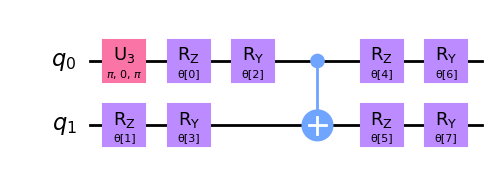

In [89]:
theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()


reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

ansatz.decompose().draw('mpl')

## Cost function via the `estimator` primitive

In [90]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [91]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session

service = QiskitRuntimeService(
    channel="ibm_quantum"
)

backend = service.backend("ibmq_qasm_simulator")
session = Session(backend=backend)

# Use estimator to get the expected values corresponding to each ansatz
estimator = Estimator(session=session)

## Classical optimizer rutine 

In [92]:
from scipy.optimize import minimize

In [93]:
# Initialize parameters
x0 = np.ones(8)

In [94]:
result = minimize(cost_func_vqe, x0, args=(ansatz, H2_Particle_Hamiltonian, estimator), method="COBYLA")

result

     fun: -0.7775614965000001
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 74
  status: 1
 success: True
       x: array([ 0.84487165,  0.96885279, -0.03196566,  2.29365969,  3.4223037 ,
        0.07085077, -0.2276787 ,  2.37523488])

## Comparison with `quiskit-nature` + `qiskit-VQE` implementation

In [2]:
! pip install qiskit-nature


[notice] A new release of pip available: 23.1.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [101]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit.algorithms.optimizers import L_BFGS_B
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

In [96]:
# Use PySCF, a classical computational chemistry software
# package, to compute the one-body and two-body integrals in
# electronic-orbital basis, necessary to form the Fermionic operator
driver = PySCFDriver(
    atom='H .0 .0 .0; H .0 .0 0.735',
    unit=DistanceUnit.ANGSTROM,
    basis='sto3g',
)
problem = driver.run()

In [97]:
mapper = ParityMapper(num_particles=problem.num_particles)

In [98]:
optimizer = L_BFGS_B()

In [10]:
estimator = Estimator()

In [99]:
ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)

In [102]:
vqe = VQE(estimator, ansatz, optimizer)
# ensure that the optimizer starts in the all-zero state which corresponds to
# the Hartree-Fock starting point
vqe.initial_point = [0] * ansatz.num_parameters

In [103]:
algorithm = GroundStateEigensolver(mapper, vqe)

In [ ]:
electronic_structure_result = algorithm.solve(problem)
electronic_structure_result.formatting_precision = 6
print(electronic_structure_result)